![image.png](https://i.imgur.com/a3uAqnb.png)

# 🧠 **Neural Networks with PyTorch: MNIST Classification**
---

In this lab, we will:
- Use **built-in dataset** of images such as **MNIST**
- Build a model class of **three-layer neural network classifier** using PyTorch
- Train the model and evaluate its performance on test data


In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.transforms.functional import to_tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 📊 **About MNIST**


<img src="https://s3.w3s.aioz.network/w3ai-platform-v2/uploads/documents/54deb202-59ab-491b-b167-e0d95f9c4eb7/2024/06/24/1719218079-39fPyGLN53MiaRknDk8wCe.png?AWSAccessKeyId=FT7EO3IGQNMIILHXIDZRVTJHWE&Signature=HlOvnFSFw2T9o7yc2Xp3qfbb3Ao%3D&Expires=2349938079" width="50%">

MNIST is a **built-in** dataset of **grayscale handwritten digit images (0–9)**.

The dataset contains **60,000 training images** and **10,000 testing images**, each of size **28 × 28 pixels**.



### 🔹**Prepare Data**


> We load the MNIST dataset by creating separate **training** and **testing** dataset objects and applying a tensor transformation to each image.




In [2]:
# Training dataset
train_dataset = MNIST(
    root='./datasets',     # Dataset storage path
    train=True,            # Use training data
    transform=to_tensor,   # Convert images to tensors
    download=True          # Download if not available
)

# Testing dataset
test_dataset = MNIST(
    root='./datasets',     # Dataset storage path
    train=False,           # Use test data
    transform=to_tensor,   # Convert images to tensors
    download=True          # Download if not available
)

# print one sample from the dataset
# Each sample consists of an image tensor and its label
sample_image, sample_label = train_dataset[0]

print(f"\n Image shape: {sample_image.shape}")  # (1, 28, 28)
print(f"Label: {sample_label}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]


 Image shape: torch.Size([1, 28, 28])
Label: 5




> We use **DataLoaders** to group the training and testing datasets into mini-batches and feed them efficiently to the model during training and evaluation.



In [3]:
# DataLoader for training data
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)
# DataLoader for test/validation data
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)
# Get the first batch from the training DataLoader
X_batch, y_batch = next(iter(train_loader))
print(f"Training batch input shape: {X_batch.shape}")
print(f"Training batch labels shape: {y_batch.shape}")

Training batch input shape: torch.Size([32, 1, 28, 28])
Training batch labels shape: torch.Size([32])




> Lets display some images !



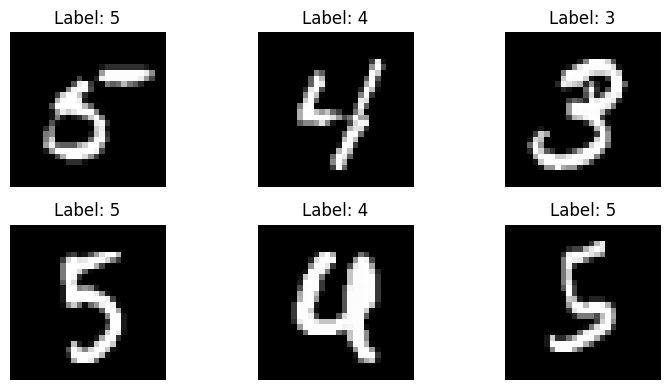

In [4]:
# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Display the first 6 images in the batch
plt.figure(figsize=(8, 4))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()



> Data now is ready for the model ! Lets build the model class.

---



### 🔹**Model Class**


Let’s create the **architecture of our model** by implementing a **three-layer neural network classifier**.

Instead of **sigmoid**, we use **softmax** at the output layer:
- **Sigmoid** outputs values in the range (0, 1)
- **Softmax** converts a vector into probabilities that sum to 1

Softmax formula: $$\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$


In [5]:
class NN3Layer(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN3Layer, self).__init__()

        # First linear layer: input features -> hidden layer
        self.layer1 = nn.Linear(input_dim, hidden_dim)

        # Second linear layer: hidden layer -> hidden layer
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)

        # Output layer: hidden layer -> number of classes (logits)
        self.layer3 = nn.Linear(hidden_dim, output_dim)#10 output

        # ReLU activation for non-linearity
        self.relu = nn.ReLU()

    # Defines how input data flows through the network
    def forward(self, x):
        # First hidden layer
        z1 = self.layer1(x)
        a1 = self.relu(z1)

        # Second hidden layer
        z2 = self.layer2(a1)
        a2 = self.relu(z2)

        # Output layer (raw scores / logits)
        output = self.layer3(a2) # there is something missing here, remember? :)

        return output


📌 **Note on Softmax**

The output of this model consists of **raw scores (logits)**, not probabilities.  
When using `CrossEntropyLoss`, **Softmax is applied internally**, so it should **not** be included in the model’s architecture.

Softmax can be applied **only during evaluation** if class probabilities are needed.

---

### 🔹**Training Loop**

In [6]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    # Set the model to training mode
    model.train()

    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move batch to the selected device
        X_batch = X_batch.view(X_batch.size(0), -1).to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch) # shape: (batch_size, 10)
        loss = criterion(outputs, y_batch)

        # Backward pass & optimization
        optimizer.zero_grad()   # Clear previous gradients
        loss.backward()         # Compute gradients
        optimizer.step()        # Update model parameters

        running_loss += loss.item()

    # Average loss over all batches
    avg_loss = running_loss / len(train_loader)

    return avg_loss

### 🔹**Validation Loop**

In [7]:
def validate(model, criterion, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to device
            X_batch = X_batch.view(X_batch.size(0), -1).to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)  # shape: (batch_size, 10)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

            # Apply Softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Multiclass predictions
            predicted = torch.argmax(probabilities, dim=1)

            # Accuracy calculation
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total

    return avg_loss, accuracy


### 🔹**Running Training**

In [8]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
input_dim = 28 * 28   # MNIST images flattened
hidden_dim = 14      # Design choice
output_dim = 10       # Digits 0–9

# Instantiate model
model = NN3Layer(input_dim, hidden_dim, output_dim).to(device)

# Print the model architecture
print("Model Architecture:\n")
print(model)

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")

Model Architecture:

NN3Layer(
  (layer1): Linear(in_features=784, out_features=14, bias=True)
  (layer2): Linear(in_features=14, out_features=14, bias=True)
  (layer3): Linear(in_features=14, out_features=10, bias=True)
  (relu): ReLU()
)

Total trainable parameters: 11350


In [9]:
num_epochs = 10
learning_rate = 0.001

# Define criterion (loss function) - using CrossEntropyLoss as model now outputs logits
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = Adam(model.parameters(), learning_rate)

In [10]:
# Run Training
train_losses = []
val_losses = []
val_accuracies = []

print('Starting Training...')
for epoch in range(num_epochs):
    # Train one epoch
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)

    # Validate
    val_loss, val_accuracy = validate(model, criterion, test_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

print('Training Complete!')

Starting Training...
Epoch [1/10], Train Loss: 0.5654, Val Loss: 0.3203, Val Accuracy: 0.9093
Epoch [2/10], Train Loss: 0.2937, Val Loss: 0.2632, Val Accuracy: 0.9216
Epoch [3/10], Train Loss: 0.2418, Val Loss: 0.2260, Val Accuracy: 0.9338
Epoch [4/10], Train Loss: 0.2135, Val Loss: 0.2082, Val Accuracy: 0.9380
Epoch [5/10], Train Loss: 0.1978, Val Loss: 0.1970, Val Accuracy: 0.9435
Epoch [6/10], Train Loss: 0.1866, Val Loss: 0.1918, Val Accuracy: 0.9439
Epoch [7/10], Train Loss: 0.1772, Val Loss: 0.1841, Val Accuracy: 0.9464
Epoch [8/10], Train Loss: 0.1697, Val Loss: 0.1878, Val Accuracy: 0.9452
Epoch [9/10], Train Loss: 0.1628, Val Loss: 0.1845, Val Accuracy: 0.9475
Epoch [10/10], Train Loss: 0.1559, Val Loss: 0.1824, Val Accuracy: 0.9477
Training Complete!




> Lets see what train and validation losses look like



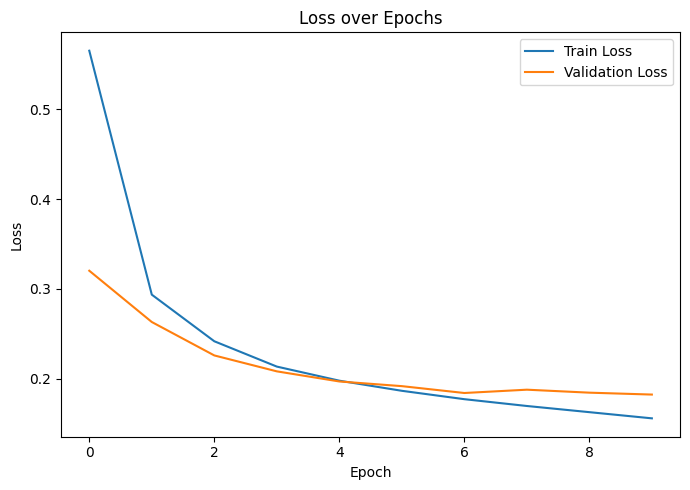

In [11]:
# Plotting results
plt.figure(figsize=(7, 5))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



> lets plot some predictions from our model



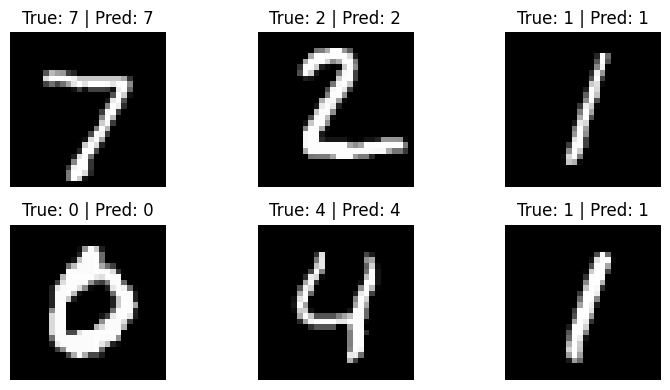

In [12]:
# Set model to evaluation mode
model.eval()
# Get one batch from the test DataLoader
images, labels = next(iter(test_loader))
# Move images to device
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    # Flatten images before passing to the model
    outputs = model(images.view(images.size(0), -1))
    predictions = torch.argmax(outputs, dim=1)

# Move tensors back to CPU for plotting
images = images.cpu()
labels = labels.cpu()
predictions = predictions.cpu()

# Plot first 6 predictions
plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"True: {labels[i]} | Pred: {predictions[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### 💾 **Saving the Model**

After training, we can save the model so it can be **reused later without retraining**.  
In PyTorch, the recommended approach is to save the model’s **state dictionary**, which contains all learned parameters.

In [13]:
# Save the trained model parameters
torch.save(model.state_dict(), "mnist_nn3layer.pth")

print("Model saved successfully!")

Model saved successfully!




> if you want to use the model :



In [14]:
# Recreate the model architecture
model = NN3Layer(input_dim, hidden_dim, output_dim)
# Load saved parameters
model.load_state_dict(torch.load("mnist_nn3layer.pth"))
# Set model to evaluation mode
model.eval()
print("Model loaded successfully!")

Model loaded successfully!




<img src="https://miro.medium.com/v2/resize:fit:1270/0*EmoDsauYmQMih_So" width="30%">

### **Contributed by: Yara Alzahrani**